## Imports

In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt



from vdw_evolve import allign_along_10
from vdw_evolve import AnnealingSolver, MechanicSolver, GeneticSolver
from vdw_evolve import SuperLattice

matplotlib.use('nbagg')

# Imput 

In [2]:
graphene_xyz_path = "../zx_files/graphene.xyz"
pbse_xyz_path = "../zx_files/PdSe2.xyz"

graphene_cell = np.array([[2.467, 2.467 / 2], [0, 2.467 * np.sqrt(3) / 2]])
pbse_cell = np.array([[5.75, 0], [0, 5.92]])

aligned_cells = allign_along_10([graphene_cell, pbse_cell])
graphene_cell = aligned_cells[0]
pbse_cell = aligned_cells[1]

## Runn solvers 

In [3]:
from vdw_evolve.parser import extract_molecule

def t_units_to_x(molec, cel):

    print("molec:", molec)
    a1 = np.array([cel[0,0],cel[1,0]])
    a2 = np.array([cel[1,0],cel[1,1]])
    new_m ={}
    for atom in molec:
        print(a1*molec[atom]["x"])
        r = molec[atom]["x"]*a1 + molec[atom]["y"]*a2
        new_m[atom]=r.T
        new_m[atom]= np.append(new_m[atom],molec[atom]["z"])  #z
    print("new_m:", new_m)
    return new_m



class SuperLattice:
    def __init__(self, super_cell, path_xyz1, path_xyz2):

        self.s_cell = super_cell.cell
        self.cells = super_cell.parents
        self.lattices = [t_units_to_x(extract_molecule(path_xyz1), self.cells[0]),
                         t_units_to_x(extract_molecule(path_xyz2), self.cells[1])]
        self.s_lattice = self.s_lattice_()
        self.nr_atoms = len(self.s_lattice)

    def s_lattice_(self):

        # print("\n\ns_cell",self.s_cell)
        # take atoms from 1st lattice:
        cell_atoms = {}
        for i, cell in enumerate(self.cells):
            a1s, a2s = self.get_scales(cell)
            print("ssl",self.lattices)
            atomic_grid = atom_grid(self.lattices[i], cell, a1s, a2s)


            for atom in atomic_grid:
                if in_cell_check(atomic_grid[atom], self.s_cell):
                    cell_atoms["l" + str(i) + "_" + atom] = atomic_grid[atom]
        # print("cell_atoms:\n",cell_atoms)
        return cell_atoms

    def get_scales(self, cell_x):
        s_cell = self.s_cell
        c0 = np.array([0, 0])
        c1 = np.array([s_cell[0][0], s_cell[1][0]])
        c2 = np.array([s_cell[0][1], s_cell[1][1]])
        c3 = c1 + c2

        c_ = [c0, c1, c2, c3]

        d = [np.sqrt(c[0] ** 2 + c[1] ** 2) for c in c_]

        a1s = int(max(d) / np.sqrt(cell_x.T[0][0] ** 2 + cell_x.T[0][1])) + 1
        a2s = int(max(d) / np.sqrt(cell_x.T[1][0] ** 2 + cell_x.T[1][1])) + 1

        return a1s, a2s

    def to_xyz(self, path =None):
        xyz = str(self.nr_atoms)+"\n\n"
        for atom in self.s_lattice:
            xyz = xyz+ str(atom)+" "
            v= (self.s_lattice[atom][0],self.s_lattice[atom][1])
            x,y = t1t2(v,self.s_cell)
            xyz = xyz + str(x)+" "+str(y)+" "+str(self.s_lattice[atom][2])+"\n"
        if path!=None:
            with open(path, 'w') as f:
                f.write(xyz)
        return xyz



def atom_grid(lattice, cell_x, a1s, a2s):
    atoms = {}

    for e, atom in enumerate(lattice):
        atom_x = lattice[atom][0]
        atom_y = lattice[atom][1]
        counter = 1
        for i in range(-a1s, a1s):
            for j in range(-a2s, a2s):
                x = atom_x + i * cell_x.T[0][0] + j * cell_x.T[1][0]
                y = atom_y + i * cell_x.T[0][1] + j * cell_x.T[1][1]
#                 print("llla:\n",lattice[atom])
                atoms[str(counter) + "_" + atom] = [x, y,lattice[atom][2]]
                counter += 1
    return atoms


# v = t1C1+t2C2
# v0 = t1c10 + t2c20
# v1 = t1c11 + t2c21
# v0*c11 = t1c10c11 +t2c20c11
# v1*c10 = t1c11c10 +t2c21c10
# v0*c11-v1*c10= t2(c20c11-t2c21c10) => t2= (v0*c11-v1*c10)/(c20c11-c21c10)

def in_cell_check(v, cell):
    c1 = cell.T[0]
    c2 = cell.T[1]
    t2 = (v[0] * c1[1] - v[1] * c1[0]) / (c2[0] * c1[1] - c2[1] * c1[0])
    t1 = (v[0] - t2 * c2[0]) / c1[0]

    if 0 < t1 <= 1 and 0 < t2 <= 1:
        return True
    else:
        return False

def t1t2(v,cell):
    c1 = cell.T[0]
    c2 = cell.T[1]
    t2 = (v[0] * c1[1] - v[1] * c1[0]) / (c2[0] * c1[1] - c2[1] * c1[0])
    t1 = (v[0] - t2 * c2[0]) / c1[0]
    return t1,t2



### AnnealingSolver

In [4]:
print("\n\nAnnealingSolver:")
solver1 = AnnealingSolver()
solver1.model_par["strain_boundary"] = [[-0.05, 0.05], [-0.05, 0.05]]
solver1.nr_epochs = 11

# Calculate super cell
super_cell_annealing = solver1.solve(graphene_cell, pbse_cell)
annealing_lattice = SuperLattice(super_cell_annealing, graphene_xyz_path, pbse_xyz_path)



AnnealingSolver:
temp:4|epoch:0|change:-26923911230191.793|value:1515521726416.549
temp:4|epoch:5|change:213814268857.5191|value:19398714867.28693
temp:4|epoch:10|change:5482148422181.174|value:19398714867.28693
temp:0.0975609756097561|epoch:0|change:25795906256588.945|value:19398714867.28693
temp:0.0975609756097561|epoch:5|change:76916631095.18655|value:19398714867.28693
temp:0.0975609756097561|epoch:10|change:3907132260720.798|value:19398714867.28693
temp:0.04938271604938272|epoch:0|change:17274357149056.152|value:19398714867.28693
temp:0.04938271604938272|epoch:5|change:40681000916197.234|value:19398714867.28693
temp:0.04938271604938272|epoch:10|change:1312358277677.004|value:12086743228.332747
temp:0.03305785123966942|epoch:0|change:-1801438239.1779823|value:10285304989.154764
temp:0.03305785123966942|epoch:5|change:540948880147.86426|value:147355073.25331956
temp:0.03305785123966942|epoch:10|change:463880548661.34326|value:147355073.25331956
temp:0.02484472049689441|epoch:0|chan

temp:0.0031225604996096804|epoch:10|change:15934594888886.105|value:147355073.25331956
temp:0.0030280090840272525|epoch:0|change:10200977656629.455|value:147355073.25331956
temp:0.0030280090840272525|epoch:5|change:1006572394923427.9|value:147355073.25331956
temp:0.0030280090840272525|epoch:10|change:4976422654227.045|value:147355073.25331956
temp:0.0029390154298310073|epoch:0|change:6164809025462.833|value:147355073.25331956
temp:0.0029390154298310073|epoch:5|change:13052078872583.42|value:147355073.25331956
temp:0.0029390154298310073|epoch:10|change:471074606738.4297|value:147355073.25331956
temp:0.002855103497501785|epoch:0|change:1000192132689238.8|value:147355073.25331956
temp:0.002855103497501785|epoch:5|change:40137125797045.13|value:147355073.25331956
temp:0.002855103497501785|epoch:10|change:66926225633.48648|value:147355073.25331956
temp:0.0027758501040943797|epoch:0|change:24291831925695.48|value:147355073.25331956
temp:0.0027758501040943797|epoch:5|change:36393122042399.36|

temp:0.0015145778114350628|epoch:10|change:6687969879785.89|value:147355073.25331956
temp:0.001491980604252145|epoch:0|change:4538737826463.602|value:147355073.25331956
temp:0.001491980604252145|epoch:5|change:40258159369806.41|value:147355073.25331956
temp:0.001491980604252145|epoch:10|change:11238325656204.104|value:147355073.25331956
temp:0.001470047776552738|epoch:0|change:6419540216264.29|value:147355073.25331956
temp:0.001470047776552738|epoch:5|change:756465768162.8552|value:147355073.25331956
temp:0.001470047776552738|epoch:10|change:25104606962782.47|value:147355073.25331956
temp:0.0014487504527345167|epoch:0|change:1804283707452.4216|value:147355073.25331956
temp:0.0014487504527345167|epoch:5|change:259937807422.1874|value:147355073.25331956
temp:0.0014487504527345167|epoch:10|change:40613628193153.29|value:147355073.25331956
temp:0.0014280614066404858|epoch:0|change:66707140433861.055|value:147355073.25331956
temp:0.0014280614066404858|epoch:5|change:8615176960745.848|value:

temp:0.0009898539965355103|epoch:10|change:8506493358801.468|value:147355073.25331956
temp:0.0009801519235481493|epoch:0|change:483253782717.97546|value:147355073.25331956
temp:0.0009801519235481493|epoch:5|change:313612113019.39|value:147355073.25331956
temp:0.0009801519235481493|epoch:10|change:24945529286818.645|value:147355073.25331956
temp:0.0009706381946129574|epoch:0|change:9911383982870.352|value:147355073.25331956
temp:0.0009706381946129574|epoch:5|change:250935338466.43124|value:147355073.25331956
temp:0.0009706381946129574|epoch:10|change:22203819458626.832|value:147355073.25331956
temp:0.0009613073780341257|epoch:0|change:6588500410300.659|value:147355073.25331956
temp:0.0009613073780341257|epoch:5|change:1000000011072555.6|value:147355073.25331956
temp:0.0009613073780341257|epoch:10|change:33951772505949.055|value:147355073.25331956
temp:0.0009521542489883355|epoch:0|change:2091723122131.5486|value:147355073.25331956
temp:0.0009521542489883355|epoch:5|change:161637242221.4

temp:0.0007406035919274203|epoch:5|change:47036272417456.12|value:147355073.25331956
temp:0.0007406035919274203|epoch:10|change:24141462365359.504|value:147355073.25331956
temp:0.0007351589781290198|epoch:0|change:1210665278527.5156|value:147355073.25331956
temp:0.0007351589781290198|epoch:5|change:1000000987771195.2|value:147355073.25331956
temp:0.0007351589781290198|epoch:10|change:17398961556793.275|value:147355073.25331956
temp:0.0007297938332421085|epoch:0|change:9820089146269.043|value:147355073.25331956
temp:0.0007297938332421085|epoch:5|change:2497608032511.5107|value:147355073.25331956
temp:0.0007297938332421085|epoch:10|change:14759671665733.389|value:147355073.25331956
temp:0.0007245064299945656|epoch:0|change:234740568177.88565|value:147355073.25331956
temp:0.0007245064299945656|epoch:5|change:95125526136343.0|value:147355073.25331956
temp:0.0007245064299945656|epoch:10|change:74918800981.83363|value:147355073.25331956
temp:0.0007192950908110046|epoch:0|change:1024723014836

temp:0.0005951495313197438|epoch:5|change:270445546456.78043|value:147355073.25331956
temp:0.0005951495313197438|epoch:10|change:1310481588730.6472|value:147355073.25331956
temp:0.0005916284573287973|epoch:0|change:132619983887.11832|value:147355073.25331956
temp:0.0005916284573287973|epoch:5|change:20237288830772.348|value:147355073.25331956
temp:0.0005916284573287973|epoch:10|change:10143675158566.998|value:147355073.25331956
temp:0.0005881488016468163|epoch:0|change:24594222155571.703|value:147355073.25331956
temp:0.0005881488016468163|epoch:5|change:17758250067340.484|value:147355073.25331956
temp:0.0005881488016468163|epoch:10|change:12711735160803.988|value:147355073.25331956
temp:0.0005847098377430197|epoch:0|change:6346178276567.931|value:147355073.25331956
temp:0.0005847098377430197|epoch:5|change:60160548796178.83|value:147355073.25331956
temp:0.0005847098377430197|epoch:10|change:15281097511743.39|value:147355073.25331956
temp:0.0005813108559802352|epoch:0|change:51292722095

temp:0.0004949882440292043|epoch:10|change:165255873639.6013|value:147355073.25331956
temp:0.0004925501785494397|epoch:0|change:19429187155435.645|value:147355073.25331956
temp:0.0004925501785494397|epoch:5|change:3778120623.4817066|value:147355073.25331956
temp:0.0004925501785494397|epoch:10|change:188931039190.94778|value:147355073.25331956
temp:0.0004901360127435363|epoch:0|change:961518764633.7369|value:147355073.25331956
temp:0.0004901360127435363|epoch:5|change:3956396109512.2163|value:147355073.25331956
temp:0.0004901360127435363|epoch:10|change:33873153347461.848|value:147355073.25331956
temp:0.0004877453969028167|epoch:0|change:22871575567960.016|value:147355073.25331956
temp:0.0004877453969028167|epoch:5|change:24542504041396.688|value:147355073.25331956
temp:0.0004877453969028167|epoch:10|change:5242704749236.823|value:147355073.25331956
temp:0.00048537798810823927|epoch:0|change:117539556520882.38|value:147355073.25331956
temp:0.00048537798810823927|epoch:5|change:558116684

temp:0.00042548665035634537|epoch:5|change:3258283846517.462|value:147355073.25331956
temp:0.00042548665035634537|epoch:10|change:6312333262861.4375|value:147355073.25331956
temp:0.00042368393178688723|epoch:0|change:8125433697981.834|value:147355073.25331956
temp:0.00042368393178688723|epoch:5|change:22094626475910.316|value:147355073.25331956
temp:0.00042368393178688723|epoch:10|change:59994808638.28327|value:147355073.25331956
temp:0.00042189642442780323|epoch:0|change:7959754111149.218|value:147355073.25331956
temp:0.00042189642442780323|epoch:5|change:14641563827063.889|value:147355073.25331956
temp:0.00042189642442780323|epoch:10|change:804172882911.0354|value:147355073.25331956
temp:0.00042012393656128583|epoch:0|change:23402696267516.83|value:147355073.25331956
temp:0.00042012393656128583|epoch:5|change:4542855042870.548|value:147355073.25331956
temp:0.00042012393656128583|epoch:10|change:21287243176.057198|value:147355073.25331956
temp:0.0004183662796778582|epoch:0|change:5425

temp:0.00037309952429810705|epoch:5|change:527453810621.7892|value:99670862.85289851
temp:0.00037309952429810705|epoch:10|change:2794720135110.9155|value:99670862.85289851
temp:0.00037171266610909817|epoch:0|change:435927514756.7277|value:99670862.85289851
temp:0.00037171266610909817|epoch:5|change:13069059435945.215|value:99670862.85289851
temp:0.00037171266610909817|epoch:10|change:5714971744180.853|value:99670862.85289851
temp:0.0003703360799925938|epoch:0|change:3208336642211.3813|value:99670862.85289851
temp:0.0003703360799925938|epoch:5|change:219870879763.58917|value:99670862.85289851
temp:0.0003703360799925938|epoch:10|change:19064022054282.97|value:99670862.85289851
temp:0.0003689696522461033|epoch:0|change:1000000001174001.0|value:99670862.85289851
temp:0.0003689696522461033|epoch:5|change:531759705205.5432|value:99670862.85289851
temp:0.0003689696522461033|epoch:10|change:25484430899014.855|value:99670862.85289851
temp:0.0003676132708390778|epoch:0|change:1860397609562.1555|

temp:0.000333305557870178|epoch:5|change:2435323930401.0356|value:99670862.85289851
temp:0.000333305557870178|epoch:10|change:7054622536967.468|value:99670862.85289851
temp:0.0003321983223984724|epoch:0|change:4727085353.764064|value:99670862.85289851
temp:0.0003321983223984724|epoch:5|change:8355060856993.872|value:99670862.85289851
temp:0.0003321983223984724|epoch:10|change:5920127363610.297|value:99670862.85289851
temp:0.0003310984190050497|epoch:0|change:31646283997468.023|value:99670862.85289851
temp:0.0003310984190050497|epoch:5|change:8007486485710.771|value:99670862.85289851
temp:0.0003310984190050497|epoch:10|change:89732481657.08244|value:99670862.85289851
temp:0.00033000577510106473|epoch:0|change:53740976989766.69|value:99670862.85289851
temp:0.00033000577510106473|epoch:5|change:33460110291072.93|value:99670862.85289851
temp:0.00033000577510106473|epoch:10|change:24679544226635.062|value:99670862.85289851
temp:0.00032892031905270994|epoch:0|change:3907426044975.4966|value:

temp:0.0003002777569251561|epoch:10|change:8738182184712.855|value:99670862.85289851
temp:0.0002993787890127988|epoch:0|change:41942375389675.35|value:99670862.85289851
temp:0.0002993787890127988|epoch:5|change:54961712870.180824|value:99670862.85289851
temp:0.0002993787890127988|epoch:10|change:4409372856773.668|value:99670862.85289851
temp:0.00029848518767256203|epoch:0|change:14794489783044.076|value:99670862.85289851
temp:0.00029848518767256203|epoch:5|change:5165617588537.298|value:99670862.85289851
temp:0.00029848518767256203|epoch:10|change:1083176649375.336|value:99670862.85289851
temp:0.00029759690499218835|epoch:0|change:2034372568075.497|value:99670862.85289851
temp:0.00029759690499218835|epoch:5|change:29171152291794.13|value:99670862.85289851
temp:0.00029759690499218835|epoch:10|change:1687534026350.8477|value:99670862.85289851
temp:0.00029671389362806943|epoch:0|change:48874651244862.28|value:99670862.85289851
temp:0.00029671389362806943|epoch:5|change:45399808521740.016|

temp:0.00027320538214602847|epoch:5|change:20562177682627.535|value:99670862.85289851
temp:0.00027320538214602847|epoch:10|change:109550352771.90399|value:99670862.85289851
temp:0.0002724610040188|epoch:0|change:750580962709.8082|value:99670862.85289851
temp:0.0002724610040188|epoch:5|change:1557517355759.7708|value:99670862.85289851
temp:0.0002724610040188|epoch:10|change:10618206909054.805|value:99670862.85289851
temp:0.00027172067115005787|epoch:0|change:11034523904575.184|value:99670862.85289851
temp:0.00027172067115005787|epoch:5|change:4820739607654.477|value:99670862.85289851
temp:0.00027172067115005787|epoch:10|change:22085961586838.375|value:99670862.85289851
temp:0.00027098435065374984|epoch:0|change:23600289383935.234|value:99670862.85289851
temp:0.00027098435065374984|epoch:5|change:29757802211139.08|value:99670862.85289851
temp:0.00027098435065374984|epoch:10|change:2737355693430.218|value:99670862.85289851
temp:0.00027025200999932446|epoch:0|change:8898644871953.82|value:

temp:0.0002506108639809535|epoch:10|change:42083200902660.89|value:99670862.85289851
temp:0.0002499843759765014|epoch:0|change:40321979672.33431|value:99670862.85289851
temp:0.0002499843759765014|epoch:5|change:6896912126872.2295|value:99670862.85289851
temp:0.0002499843759765014|epoch:10|change:8162067286162.691|value:99670862.85289851
temp:0.00024936101240571033|epoch:0|change:8093874852.743852|value:99670862.85289851
temp:0.00024936101240571033|epoch:5|change:2107460956357.9856|value:99670862.85289851
temp:0.00024936101240571033|epoch:10|change:6358154622230.924|value:99670862.85289851
temp:0.0002487407499533611|epoch:0|change:1508244092993.1843|value:99670862.85289851
temp:0.0002487407499533611|epoch:5|change:5637580125.955398|value:99670862.85289851
temp:0.0002487407499533611|epoch:10|change:89973281393933.5|value:99670862.85289851
temp:0.0002481235655356367|epoch:0|change:1699355425888.5637|value:99670862.85289851
temp:0.0002481235655356367|epoch:5|change:21914707716168.473|value

temp:0.00023040147456943722|epoch:5|change:2007009941022.1294|value:99670862.85289851
temp:0.00023040147456943722|epoch:10|change:293864481091.5038|value:99670862.85289851
temp:0.00022987184644560657|epoch:0|change:351574795943.9847|value:99670862.85289851
temp:0.00022987184644560657|epoch:5|change:15466642307057.492|value:99670862.85289851
temp:0.00022987184644560657|epoch:10|change:7409020125822.341|value:99670862.85289851
temp:0.00022934464766928502|epoch:0|change:13827365620362.852|value:99670862.85289851
temp:0.00022934464766928502|epoch:5|change:109580207783.19223|value:99670862.85289851
temp:0.00022934464766928502|epoch:10|change:1489024379625.6292|value:99670862.85289851
temp:0.00022881986156398376|epoch:0|change:786005893089.0782|value:99670862.85289851
temp:0.00022881986156398376|epoch:5|change:8112618575547.786|value:99670862.85289851
temp:0.00022881986156398376|epoch:10|change:2312879925574.206|value:99670862.85289851
temp:0.000228297471605502|epoch:0|change:42570697017102.

temp:0.00021366380001068314|epoch:5|change:704604449884.5775|value:99670862.85289851
temp:0.00021366380001068314|epoch:10|change:654436053081.4812|value:99670862.85289851
temp:0.0002132082511593198|epoch:0|change:23170605688696.76|value:99670862.85289851
temp:0.0002132082511593198|epoch:5|change:23521674739.880978|value:99670862.85289851
temp:0.0002132082511593198|epoch:10|change:24637293701391.727|value:99670862.85289851
temp:0.00021275464071060044|epoch:0|change:2940342066681.3433|value:99670862.85289851
temp:0.00021275464071060044|epoch:5|change:14662859115747.213|value:99670862.85289851
temp:0.00021275464071060044|epoch:10|change:15017282838.714626|value:99670862.85289851
temp:0.00021230295631866669|epoch:0|change:10853958333223.928|value:99670862.85289851
temp:0.00021230295631866669|epoch:5|change:7471923352364.618|value:99670862.85289851
temp:0.00021230295631866669|epoch:10|change:17204720260246.314|value:99670862.85289851
temp:0.00021185318574228054|epoch:0|change:25835174638750

In [5]:
# print(annealing_lattice.to_xyz(path="xyz_slattice"))


In [6]:
print(super_cell_annealing.description_txt())
print("\nNr atoms  in annealing_lattice:", annealing_lattice.nr_atoms)


=== 
 cell :
[[-12.335       55.79055546]
 [  0.           6.40945401]]

cell1 :
[[2.467      1.2335    ]
 [0.         2.13648467]]

cell2 :
[[5.75 0.  ]
 [0.   5.92]]

ta :
[[-5 29]
 [ 0  3]]

strain_tb :
[[-2.14521739  9.42408031]
 [ 0.          1.08267804]]

det_ta :
-15.0

strain :
[[ 1.0726087  -0.22939795]
 [ 0.          1.08267804]]

tb :
[[-2.  9.]
 [ 0.  1.]]

diagonal_strain :
[[1.0477312  0.        ]
 [0.         1.04051816]]

diagonal_strain_tb: :
[[-2.04748831  8.99475006]
 [ 0.          1.04051817]]



Nr atoms  in annealing_lattice: 46


=== 
 cell :
[[-44.406      -62.79620875]
 [-29.604      -42.57630072]]

cell1 :
[[2.467      1.2335    ]
 [0.         2.13648467]]

cell2 :
[[5.75 0.  ]
 [0.   5.92]]

ta :
[[-18 -19]
 [-12 -13]]

strain_tb :
[[ -7.72278261 -10.60746769]
 [ -5.14852174  -7.19194269]]

det_ta :
6.000000000000009

strain :
[[ 1.02213979 -0.09086714]
 [ 0.07993872  0.90180239]]

tb :
[[ -8. -11.]
 [ -5.  -7.]]

diagonal_strain :
[[0.96484962 0.        ]
 [0.         1.02779648]]

diagonal_strain_tb: :
[[ -8.00413086 -10.99390774]
 [ -5.00928137  -6.99743856]]



Nr atoms  in annealing_lattice: 14

### MechanicSolver:

In [7]:
print("\n\nMechanicSolver:")
solver3 = MechanicSolver()
solver3.exploring_range = 50
solver3.tolerance = 0.4

# Calculate super cell
super_cell_mechanic = solver3.solve(graphene_cell, pbse_cell)
mechanic_lattice = SuperLattice(super_cell_mechanic, graphene_xyz_path, pbse_xyz_path)



MechanicSolver:
molec: {'C1': {'x': -2.26645703572323e-18, 'y': -1.8616630956906283e-38, 'z': -1.8616630956906283e-38}, 'C2': {'x': 0.6666666674727976, 'y': 0.3333333351204249, 'z': 0.3333333351204249}}
[-5.59134951e-18 -0.00000000e+00]
[1.64466667 0.        ]
new_m: {'C1': array([-5.59134951e-18, -3.97741467e-38, -1.86166310e-38]), 'C2': array([1.64466667, 0.71216156, 0.33333334])}
molec: {'Pd1': {'x': 0.4999999978360108, 'y': 1.791254318456476e-09, 'z': 1.791254318456476e-09}, 'Pd2': {'x': -1.8237131255310393e-09, 'y': 0.4999999973580771, 'z': 0.4999999973580771}, 'S1': {'x': 0.10464945368821875, 'y': 0.1114806220085412, 'z': 0.1114806220085412}, 'S2': {'x': 0.6046494606427952, 'y': 0.3885193753495359, 'z': 0.3885193753495359}, 'S3': {'x': 0.8953505401600896, 'y': 0.8885193727076129, 'z': 0.8885193727076129}, 'S4': {'x': 0.3953505332055133, 'y': 0.6114806283228899, 'z': 0.6114806283228899}}
[2.87499999 0.        ]
[-1.04863505e-08 -0.00000000e+00]
[0.60173436 0.        ]
[3.4767344

In [8]:
print(super_cell_mechanic.description_txt())
print("Nr atoms  in mechanic_lattice :", mechanic_lattice.nr_atoms)


=== 
 cell :
[[-17.269       0.       ]
 [  0.         29.9107854]]

cell1 :
[[2.467      1.2335    ]
 [0.         2.13648467]]

cell2 :
[[5.75 0.  ]
 [0.   5.92]]

ta :
[[-7.          4.04145188]
 [ 0.         14.        ]]

strain_tb :
[[-3.00330435  0.        ]
 [ 0.          5.05249753]]

det_ta :
-98.00000000000004

strain :
[[1.00110145 0.        ]
 [0.         1.01049951]]

tb :
[[-3.  0.]
 [ 0.  5.]]

diagonal_strain :
[[1.00099111 0.        ]
 [0.         1.01008797]]

diagonal_strain_tb: :
[[-3.00033068  0.        ]
 [ 0.          5.00203714]]


Nr atoms  in mechanic_lattice : 294


##  Visualization

In [9]:
from vdw_evolve.pretty_prints import plot_unit_cell_vectors,plot_lattice_grid,plot_cell
from vdw_evolve.pretty_prints import plot_atom_grid,plot_cell_atoms

=== 
 cell :
[[-27.137        5.65986204]
 [-17.269       -0.08856132]]

cell1 :
[[2.467      1.2335    ]
 [0.         2.13648467]]

cell2 :
[[5.75 0.  ]
 [0.   5.92]]

ta :
[[-11   9]
 [ -7   4]]

strain_tb :
[[-4.71947826  0.95605778]
 [-3.00330435 -0.01495968]]

det_ta :
19.000000000000004

strain :
[[ 0.95605778 -0.02027021]
 [-0.01495968  1.02603425]]

tb :
[[-5.  1.]
 [-3.  0.]]

diagonal_strain :
[[0.95       0.        ]
 [0.         1.00101346]]

diagonal_strain_tb: :
[[-4.96787185  1.00637661]
 [-3.00026371 -0.01494454]]



Nr atoms  in annealing_lattice: 55


Nr atoms  in annealing_lattice: 46


<IPython.core.display.Javascript object>


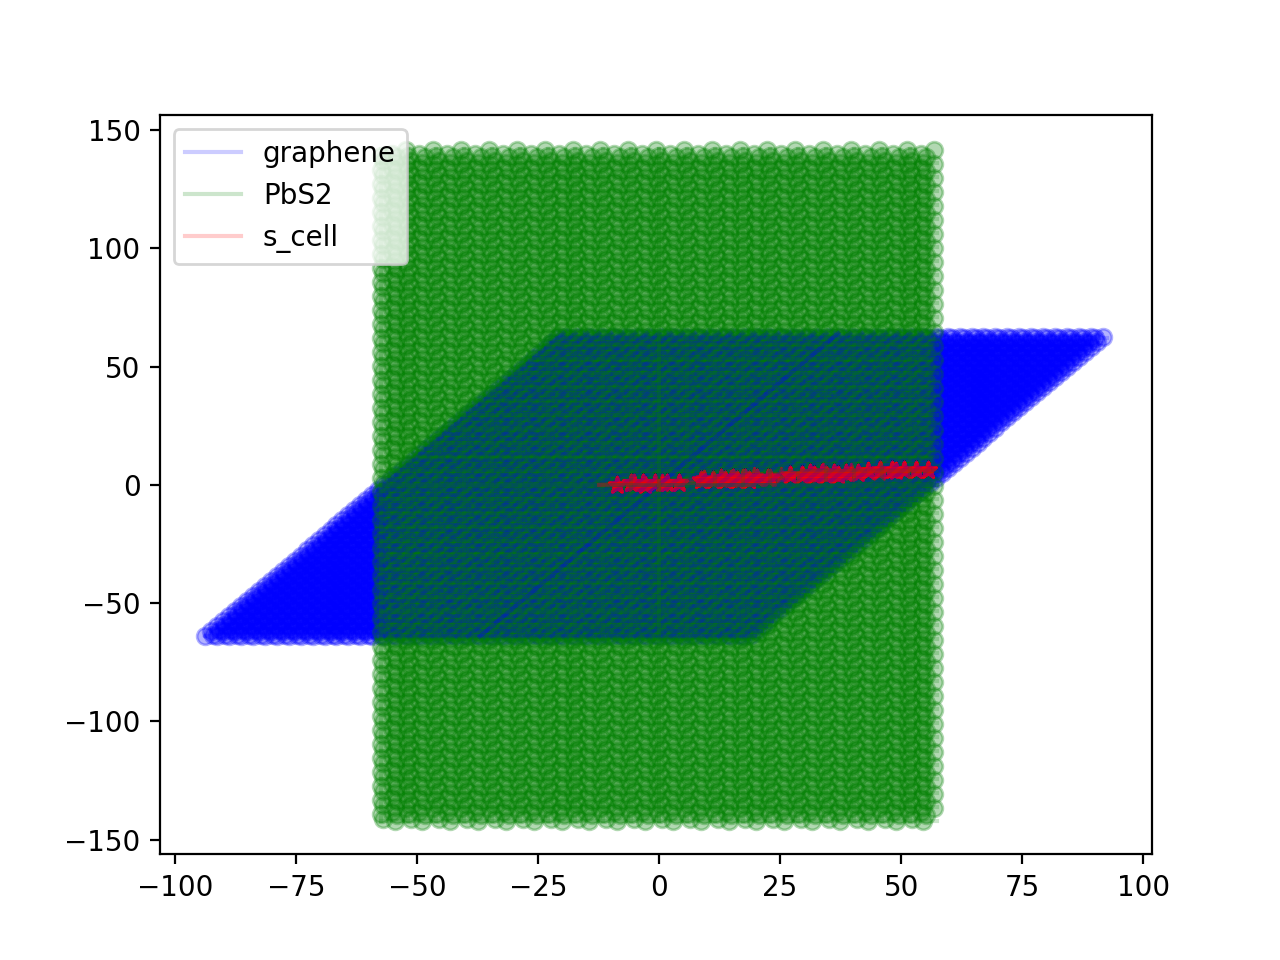

In [10]:
print("\nNr atoms  in annealing_lattice:", annealing_lattice.nr_atoms)
super_lattice = annealing_lattice

f, ax = plt.subplots()

# Plot vectors:
g_a1,g_a2= plot_unit_cell_vectors(ax, graphene_cell, alpha=0.3, color = 'b')
p_a1,p_a2= plot_unit_cell_vectors(ax, pbse_cell, alpha=0.3, color= 'g')
s_a1,s_a2= plot_unit_cell_vectors(ax, super_lattice.s_cell, alpha=0.3, color= 'r')

# Plot grid: 
graphene_grid = plot_lattice_grid(ax, super_lattice, label="graphene", parent =0, color='b', alpha =0.2)
pbse_grid = plot_lattice_grid(ax, super_lattice, label="PbS2", parent =1, color='g', alpha =0.2)

# Super cell:
super_cell = plot_cell(ax, super_lattice.s_cell, label="s_cell")

# Atoms:
graphene_atoms = plot_atom_grid(ax, super_lattice, parent = 0, color='b', alpha =0.3)
pbse_atoms = plot_atom_grid(ax, super_lattice, parent = 1, color='g', alpha =0.3)

# Atoms in Super cell:
plot_cell_atoms(super_lattice.s_lattice, marker="*", alpha=0.3, color="r")

plt.legend()
plt.show()

<IPython.core.display.Javascript object>


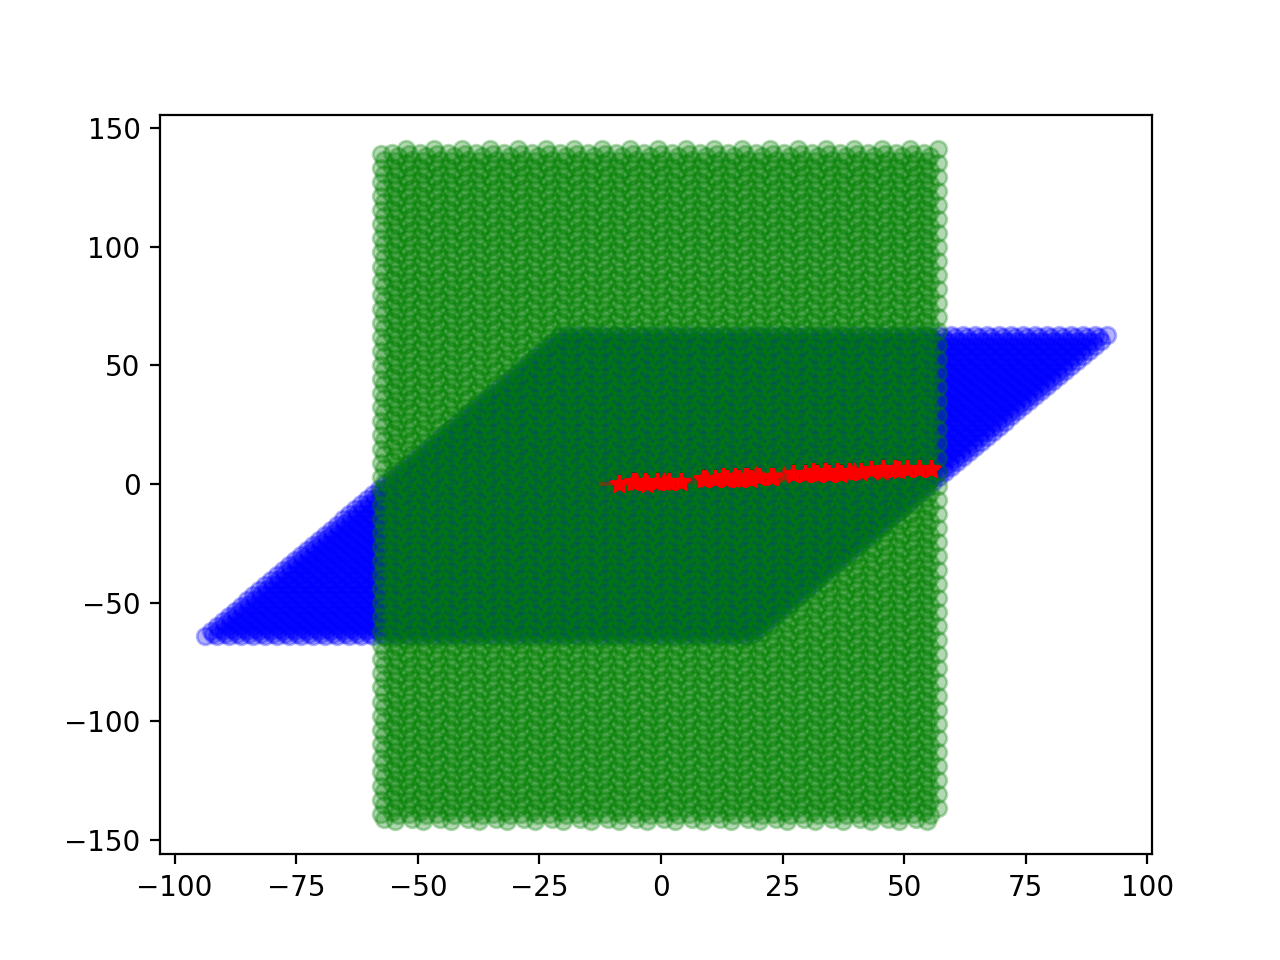

<IPython.core.display.Javascript object>


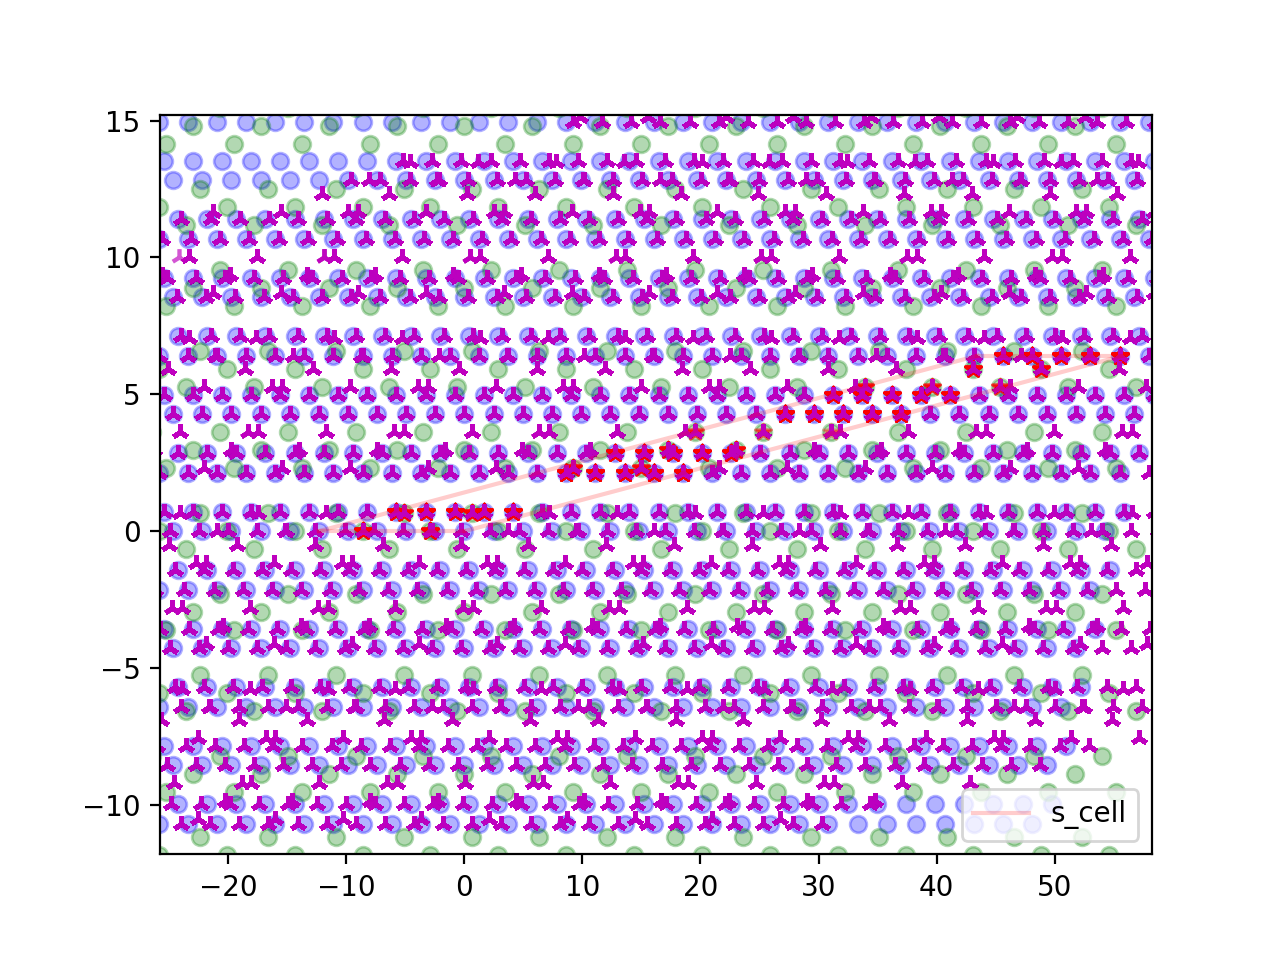

In [12]:
ag=atom_grid(lattice= super_lattice.s_lattice, cell_x=super_lattice.s_cell, a1s=10, a2s=4)

f, ax = plt.subplots()




# Atoms:
graphene_atoms = plot_atom_grid(ax, super_lattice, parent = 0, color='b', alpha =0.3)
pbse_atoms = plot_atom_grid(ax, super_lattice, parent = 1, color='g', alpha =0.3)
# Super cell:
super_cell = plot_cell(ax, super_lattice.s_cell, label="s_cell")
# Atoms in Super cell:
plot_cell_atoms(super_lattice.s_lattice, marker="*", alpha=0.3, color="r")

plot_cell_atoms(ag,color="m",marker="2",alpha=0.3)
plt.legend()
plt.show()

In [ ]:
print("Nr atoms  in mechanic_lattice :", mechanic_lattice.nr_atoms)
super_lattice = mechanic_lattice

f, ax = plt.subplots()

# Plot vectors:
g_a1,g_a2= plot_unit_cell_vectors(ax, graphene_cell, alpha=0.3, color = 'b')
p_a1,p_a2= plot_unit_cell_vectors(ax, pbse_cell, alpha=0.3, color= 'g')
s_a1,s_a2= plot_unit_cell_vectors(ax, super_lattice.s_cell, alpha=0.3, color= 'r')

# Plot grid: 
graphene_grid = plot_lattice_grid(ax, super_lattice, label="graphene", parent =0, color='b', alpha =0.2)
pbse_grid = plot_lattice_grid(ax, super_lattice, label="PbS2", parent =1, color='g', alpha =0.2)

# Super cell:
super_cell = plot_cell(ax, super_lattice.s_cell, label="s_cell")

# Atoms:
graphene_atoms = plot_atom_grid(ax, super_lattice, parent = 0, color='b', alpha =0.3)
pbse_atoms = plot_atom_grid(ax, super_lattice, parent = 1, color='g', alpha =0.3)

# Atoms in Super cell:
plot_cell_atoms(super_lattice.s_lattice, marker="*", alpha=0.3, color="r")

plt.legend()
plt.show()

In [ ]:
ag=atom_grid(lattice= super_lattice.s_lattice, cell_x=super_lattice.s_cell, a1s=1, a2s=1)

f, ax = plt.subplots()

# Atoms:
graphene_atoms = plot_atom_grid(ax, super_lattice, parent = 0, color='b', alpha =0.3)
pbse_atoms = plot_atom_grid(ax, super_lattice, parent = 1, color='g', alpha =0.3)
# Super cell:
super_cell = plot_cell(ax, super_lattice.s_cell, label="s_cell")
# Atoms in Super cell:
plot_cell_atoms(super_lattice.s_lattice, marker="*", alpha=0.3, color="r")

plot_cell_atoms(ag,color="m",marker="2",alpha=0.3,)

plt.legend()
plt.show()
